# Analyse Long Format Dataset

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
from src.d00_helpers import helpers as h
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

In [2]:
# read in long dataframe
df = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//01_processed//2024.03.21_Mastertabelle_long.xlsx',
                   parse_dates=['date'], index_col='Unnamed: 0', dtype={'vaccination': "Int64", 'infection':'Int64'})
df.rename(columns={'patient_id':'ID'}, inplace=True)

In [3]:
# read in basline table to get demographic data
bl = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//00_raw//2024.03.21_Mastertabelle.xlsx')
bl_sub=bl[['ID','Alter','Dialyse','Geschlecht']]

In [4]:
# Add information of Dialyse group
df = pd.merge(df, bl[['ID', 'Dialyse']], on='ID', how='left')

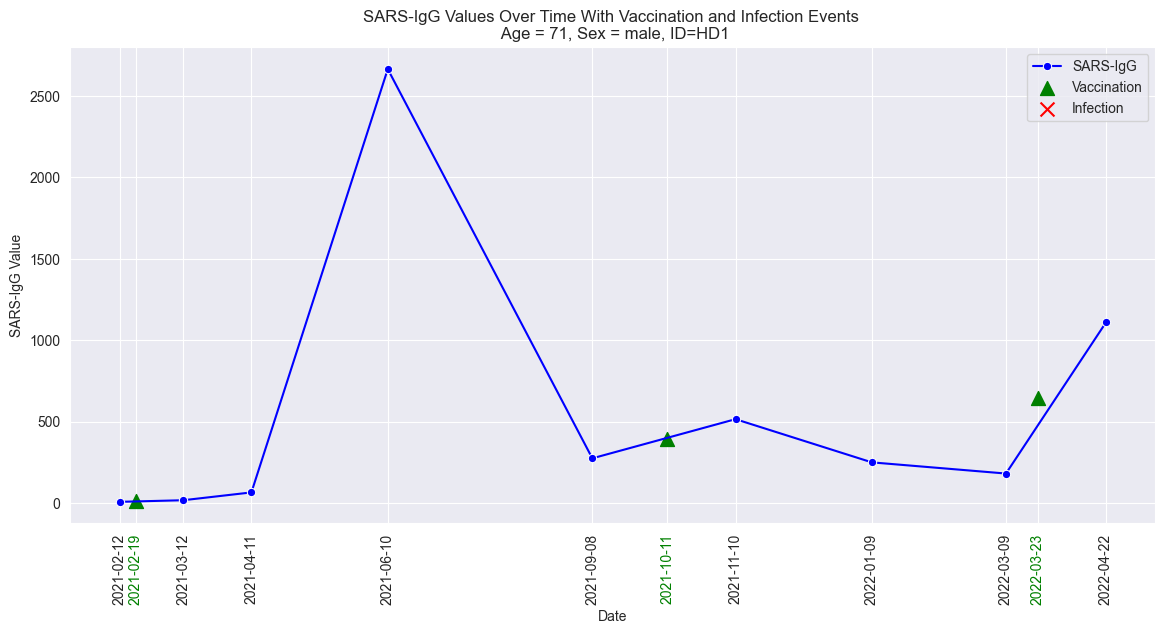

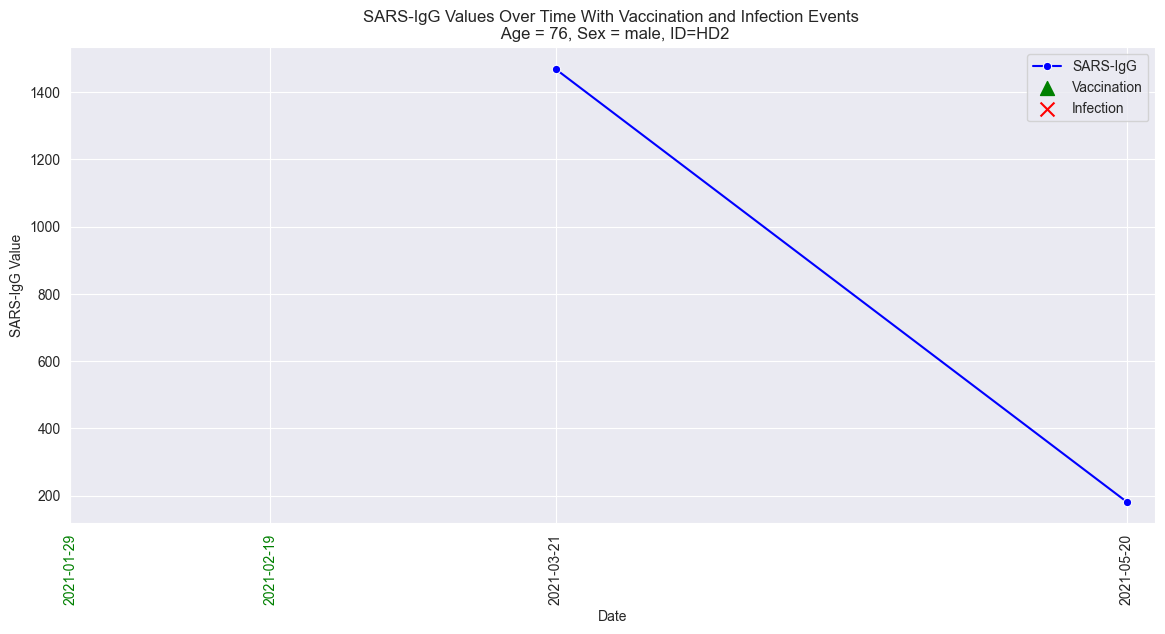

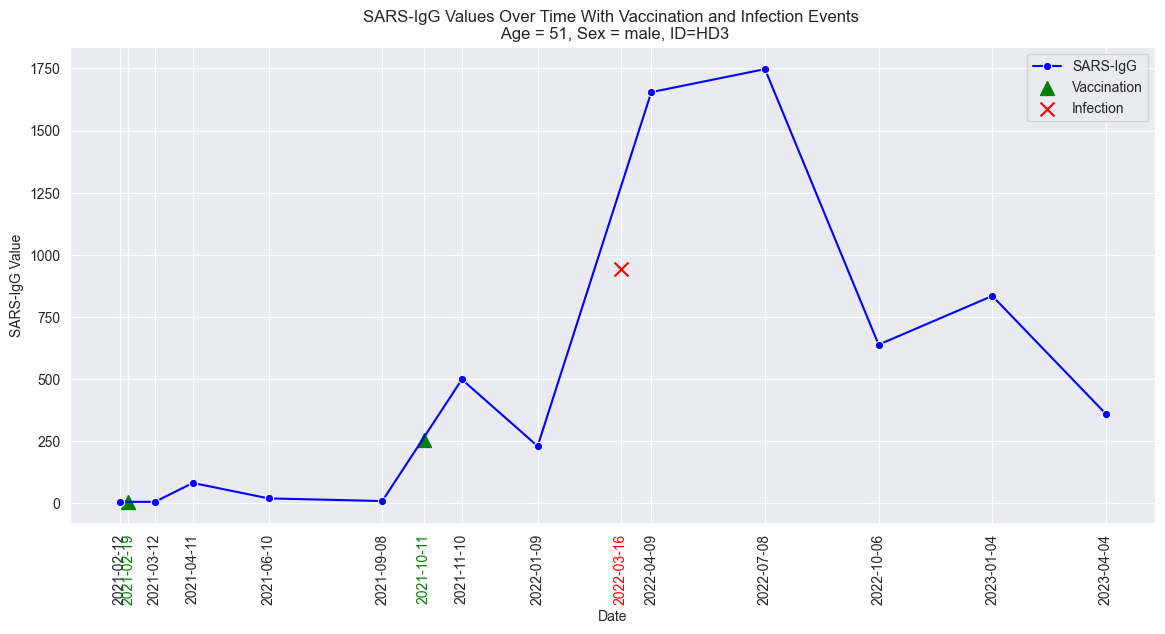

In [5]:
# loop over all patients and create single plots of their specific values
results_path = '../../results/rq1/sars-igg-plots-by-patient'
for id in df.ID.unique()[:3]:
    bl_s = bl_sub[bl_sub['ID'] == id]
    df_s = df[df['ID'] == id]
    h.plot_sars_igg_with_events(df_s, results_path, bl_s, show_plot=True)

In [6]:
# reset index for easier mapping
bl = bl.set_index('ID')

# try to aggregate values and plot these on a time axis
vaccination_groups = dict(df.groupby(['ID'])['vaccination'].sum())
infection_groups = dict(df.groupby(['ID'])['infection'].sum())

In [7]:
# count number of vaccinations and infections
bl['n_vaccinations'] = None
for id in vaccination_groups.keys():
    bl.loc[id, 'n_vaccinations'] = vaccination_groups[id]

bl['n_infections'] = None
for id in infection_groups.keys():
    bl.loc[id, 'n_infections'] = infection_groups[id]

In [8]:
# merge this information into df
sub_df = pd.merge(df, bl[['n_vaccinations','n_infections']], how='left', left_on='ID', right_index=True)
# assign group ids
sub_df['group_id'] = sub_df.groupby(['Dialyse','n_vaccinations']).ngroup()

In [9]:
# sort by date and calculate n_vaccinations and n_infections until current date
sub_df = sub_df.sort_values(by='date')
sub_df['n_vaccinations_so_far'] = sub_df.groupby('ID')['vaccination'].cumsum()
sub_df['n_infections_so_far'] = sub_df.groupby('ID')['infection'].cumsum()

In [10]:
sub_df['event'] = sub_df['infection'] | sub_df['vaccination']

In [11]:
# Ensure the DataFrame is sorted by date
sub_df.sort_values(by='date', inplace=True)

# List to hold the DataFrame of each user after applying the function
dfs = []

# Group by user_id and apply the function to each group
for _, group in sub_df.groupby('ID'):
    group_result = h.calculate_days_since_last_event(group, event_col='event')
    dfs.append(group_result)

# Concatenate all the individual user DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

## What is the correlation of SARS-IgG and days sind last event?

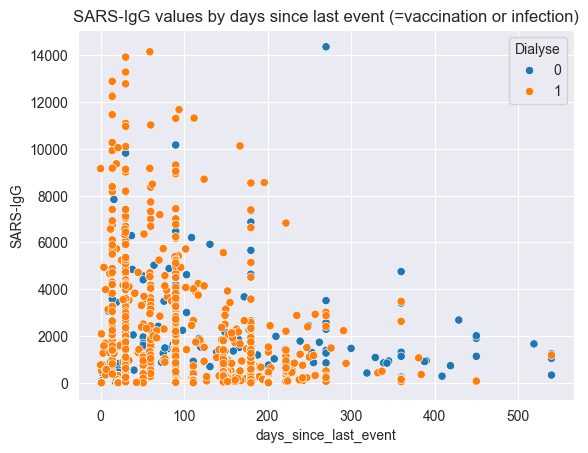

In [12]:
sub_df = result_df[result_df['days_since_last_event'] != -1]
# remove outliers
sub_df = sub_df[sub_df['SARS-IgG']<15000]


sns.scatterplot(sub_df, y='SARS-IgG', x='days_since_last_event', hue='Dialyse')
plt.title('SARS-IgG values by days since last event (=vaccination or infection)')
plt.show()

## What is the average increase in SARS-IgG after an infection?

In [18]:
res_df = pd.DataFrame(columns=['ID', 'slope', 'sars_diff'])
for id in result_df['ID'].unique():

    sub_df = result_df[result_df['ID']==id]

    # timepoint where infection happened
    infection_dates = list(sub_df[sub_df['infection']==1]['date'])

    for infection_date in infection_dates:
        try:
            res = h.calc_average_sarsigg_increase(sub_df, infection_date)

            if res:
                res['ID'] = id
                res['Dialyse'] = sub_df.Dialyse.unique().tolist()[0]
                # Create a DataFrame for the row and use pd.concat to add it to res_df
                row_df = pd.DataFrame([res])  # Encapsulate 'res' in a list to treat it as a row
                res_df = pd.concat([res_df, row_df], ignore_index=True)
        except:
            pass

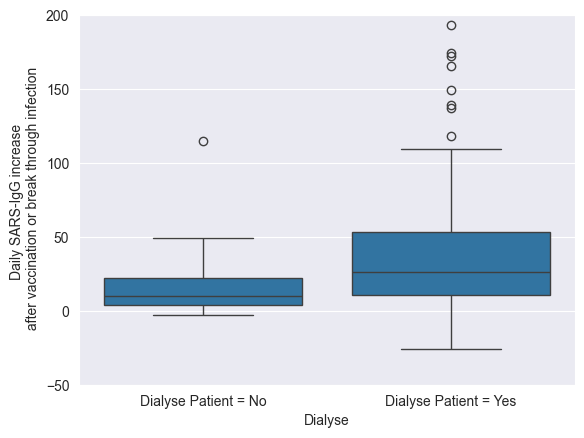

In [28]:
ax = sns.boxplot(res_df[res_df.slope<500], x='Dialyse', y='slope')

ax.set_ylim([-50, 200])

plt.ylabel('Daily SARS-IgG increase \n after vaccination or break through infection')
plt.xticks([0, 1], ['Dialyse Patient = No', 'Dialyse Patient = Yes'])


plt.show()

### Is the difference between dialyse and non-dialyse in SARS-IgG increase significant?


In [41]:


res_df[res_df['slope'] < 500]

dialyse = list(res_df[res_df['Dialyse'] == 1]['slope'])
non_dialyse = list(res_df[res_df['Dialyse'] == 0]['slope'])

ttest_ind(dialyse, non_dialyse, equal_var=False)

TtestResult(statistic=1.7068746753175175, pvalue=0.0925417068172058, df=66.06721913201626)

Groups are not statistically significant from each other!

In [42]:
res_df

,ID,slope,sars_diff,Dialyse
0,C10,-0.648667,-97.30,0.0
1,C114,18.664021,3620.82,0.0
2,C13,22.203778,1998.34,0.0
3,C132,9.744222,876.98,0.0
4,C137,3.597564,561.22,0.0
...,...,...,...,...
85,HD91,11.779091,518.28,1.0
86,HD92,19.776667,3559.80,1.0
87,HD94,36.733444,3306.01,1.0
88,HD97,139.438571,3904.28,1.0


## Check the distance in days between SARS-IgG measurements


In [54]:
# Ensure the date column is in datetime format
result_df['date'] = pd.to_datetime(result_df['date'])

# Sort the DataFrame by patient_id and date
result_df = result_df.sort_values(by=['ID', 'date'])

# Calculate the difference in days between the dates in consecutive rows for each patient
result_df['date_difference'] = result_df.groupby('ID')['date'].diff().dt.days

# Calculate the difference in days relative to the first measurement date for each patient
result_df['days_since_first_measurement'] = result_df.groupby('ID')['date'].transform(lambda x: (x - x.min()).dt.days)

In [57]:
pd.cut(result_df['days_since_first_measurement'], np.arange(0, 720, 30)).value_counts().sort_index()

days_since_first_measurement
(0, 30]       426
(30, 60]      242
(60, 90]       58
(90, 120]     188
(120, 150]     52
(150, 180]      9
(180, 210]    171
(210, 240]     73
(240, 270]    141
(270, 300]    118
(300, 330]     81
(330, 360]    125
(360, 390]     91
(390, 420]    111
(420, 450]    130
(450, 480]     28
(480, 510]     83
(510, 540]     56
(540, 570]     27
(570, 600]     85
(600, 630]     95
(630, 660]    127
(660, 690]     82
Name: count, dtype: int64

### How many measurements do we have with a time-gap of ~ one year?

In [65]:
# Define a function to apply to each group
def find_future_measurement(group):
    future_dates = []  # List to store the result for each row
    for i, row in group.iterrows():
        # Find dates between 350 to 370 days ahead
        min_date = row['date'] + pd.Timedelta(days=350)
        max_date = row['date'] + pd.Timedelta(days=370)
        future_measurements = group[(group['date'] >= min_date) & (group['date'] <= max_date)]

        # Check if there's any such measurement and act accordingly
        if not future_measurements.empty:
            future_dates.append(future_measurements.iloc[0]['date'].strftime('%Y-%m-%d'))
        else:
            future_dates.append(pd.NA)

    return pd.Series(future_dates, index=group.index)

# Apply the function to each group
result_df['future_measurement_date'] = result_df.groupby('ID').apply(find_future_measurement).reset_index(level=0, drop=True)

In [67]:
result_df[['date', 'future_measurement_date']].dropna()

,date,future_measurement_date
3,2021-04-11,2022-04-11
6,2021-10-13,2022-10-08
8,2022-01-11,2023-01-06
9,2022-04-11,2023-04-06
18,2021-06-10,2022-06-13
...,...,...
3216,2021-11-06,2022-11-01
3217,2021-11-19,2022-11-15
3233,2021-05-21,2022-05-22
3235,2021-08-19,2022-08-20


### What is the SARS-IgG course over the study?

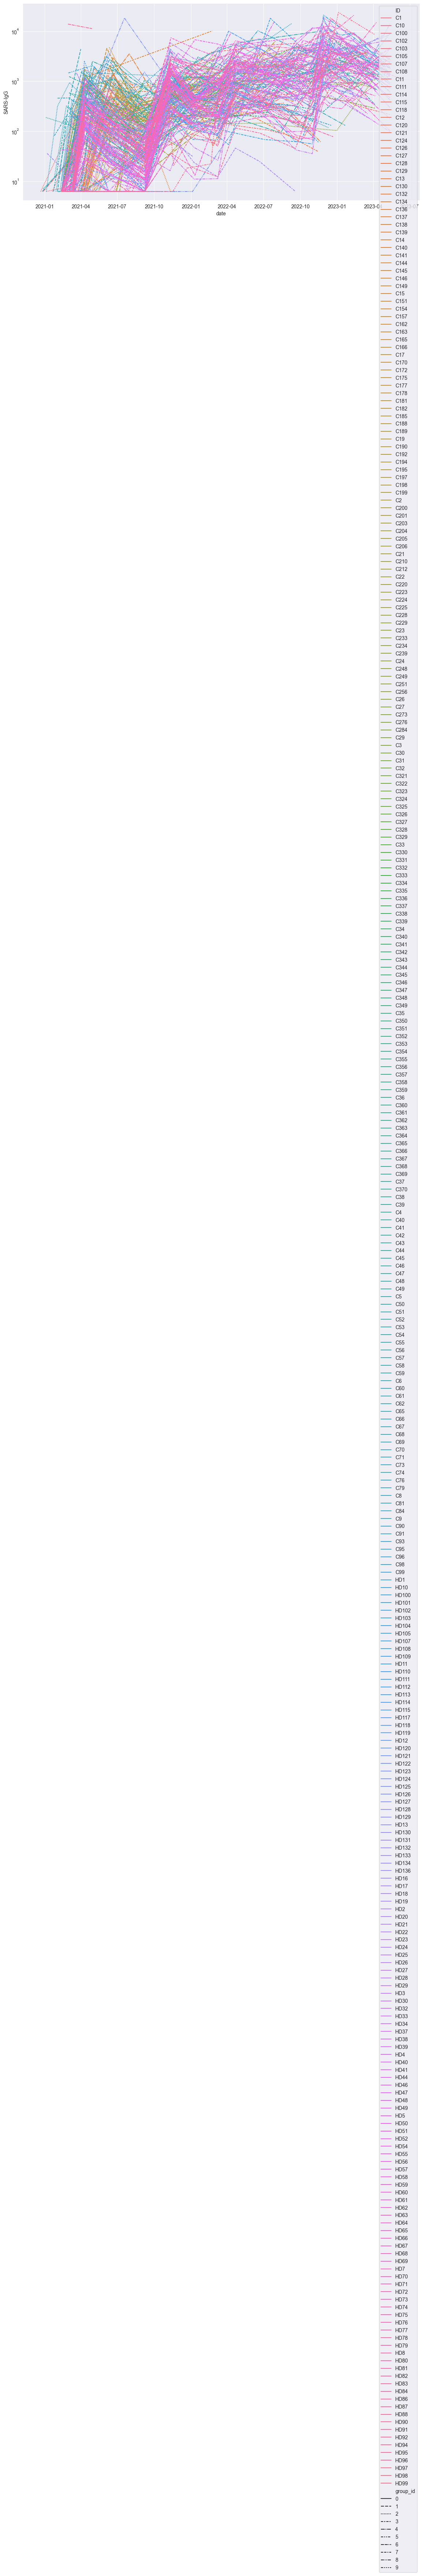

In [83]:
# Setting the plot size
plt.figure(figsize=(14, 7))

    # Plotting SARS-IgG values over time
ax = sns.lineplot(data=result_df[result_df['SARS-IgG']<30000], x='date', y='SARS-IgG', hue='ID', style='group_id')
ax.set_yscale("log")

In [77]:
result_df

,date,ID,vaccination,timepoint,SARS-IgG,infection,Dialyse,n_vaccinations,n_infections,group_id,n_vaccinations_so_far,n_infections_so_far,event,days_since_last_event,date_difference,days_since_first_measurement,future_measurement_date
0,2021-02-12,C1,0,T0,6.30,0,0,2,0,2,0,0,0,-1,NaN,0.0,<NA>
1,2021-02-19,C1,1,NaN,NaN,0,0,2,0,2,1,0,1,0,7.0,7.0,<NA>
2,2021-03-12,C1,0,T1,18.27,0,0,2,0,2,1,0,0,21,21.0,28.0,<NA>
3,2021-04-11,C1,0,T2,247.59,0,0,2,0,2,1,0,0,51,30.0,58.0,2022-04-11
4,2021-06-10,C1,0,T3,91.35,0,0,2,0,2,1,0,0,111,60.0,118.0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2021-02-28,HD99,0,T2,51.66,0,1,3,0,7,2,0,0,30,30.0,58.0,NaN
3255,2021-04-29,HD99,0,T3,20.79,0,1,3,0,7,2,0,0,90,60.0,118.0,NaN
3256,2021-07-28,HD99,0,T4,6.30,0,1,3,0,7,2,0,0,180,90.0,208.0,NaN
3257,2021-10-18,HD99,1,NaN,NaN,0,1,3,0,7,3,0,1,0,82.0,290.0,NaN
